In [2]:
import pandas as pd
import tarfile
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

## Movie metadata

In [85]:
#Importing the data
df_movie_meta = pd.read_table("./data/MovieSummaries/movie.metadata.tsv", header=None)
df_movie_meta.columns=["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", 
            "Movie box office revenue", "Movie runtime", "Movie languages", "Movie countries", "Movie genres"]

In [86]:
#Creating lists in desired columns
df_movie_meta['Movie countries'] = df_movie_meta['Movie countries'].apply(lambda x: json.loads(x)) # Converts to dictionnary
df_movie_meta['Movie countries'] = df_movie_meta['Movie countries'].apply(lambda x: list(x.values()))
df_movie_meta['Movie genres'] = df_movie_meta['Movie genres'].apply(lambda x: json.loads(x)) # Converts to dictionnary
df_movie_meta['Movie genres'] = df_movie_meta['Movie genres'].apply(lambda x: list(x.values()))
df_movie_meta['Movie languages'] = df_movie_meta['Movie languages'].apply(lambda x: json.loads(x)) # Converts to dictionnary
df_movie_meta['Movie languages'] = df_movie_meta['Movie languages'].apply(lambda x: list(x.values()))

In [87]:
#Keeping only the year of the movie
df_movie_meta.query("`Movie release date` > '1915'", inplace = True)
df_movie_meta["Movie release date"] = pd.to_datetime(df_movie_meta["Movie release date"])
df_movie_meta["Movie release date"] = df_movie_meta["Movie release date"].dt.year

In [88]:
df_movie_meta.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
72150,32566584,/m/0gm103y,Swinging with the Finkels,2011,NaN,85.0,[English Language],"[United States of America, United Kingdom]","[Romance Film, Comedy]"
5232,7347460,/m/0kv5jb,We're Not Dressing,1934,NaN,77.0,[English Language],[United States of America],"[Ensemble Film, Musical, Comedy, Musical comedy]"
25116,19280453,/m/04lg1z1,Emmanuelle 6,1988,NaN,80.0,[French Language],[France],"[Erotica, World cinema, Adult, Softcore Porn, ..."
39388,6058319,/m/0fmzhq,Where the Sky Meets the Land,2000,NaN,85.0,[English Language],[Germany],[Documentary]
44282,2317900,/m/073cyc,The Great Raid,2005,NaN,132.0,[English Language],"[United States of America, Australia]","[Action, Drama, War film]"
46262,5812638,/m/0f6l58,Midnight Run for Your Life,1994,NaN,86.0,[English Language],[United States of America],"[Thriller, Comedy film, Action, Drama]"
49499,32115658,/m/0gx22gg,Most Wanted,2011,NaN,NaN,[],[],[Action]
78088,21397519,/m/05f36qd,The Phantom Horse,1955,NaN,90.0,[Japanese Language],[Japan],"[Drama, Adventure]"
39568,9836112,/m/02ptj0d,Christabel,1988,NaN,NaN,[English Language],[United Kingdom],"[Biographical film, Drama, Docudrama]"
79370,22643388,/m/05znq3z,Mottige Janus,1922,NaN,70.0,[],[Netherlands],[Silent film]


Text(0.5, 1.0, 'Number of movie released in each year')

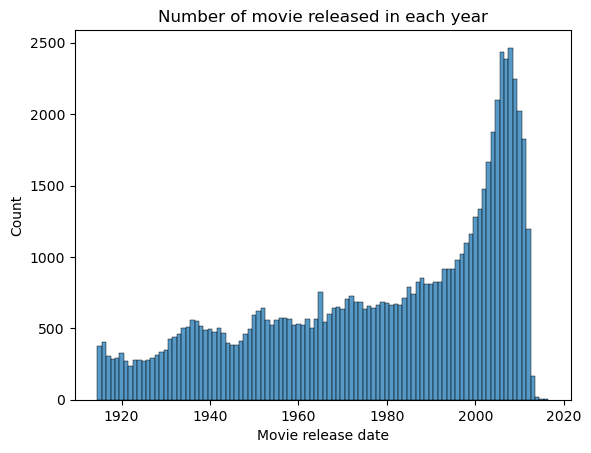

In [97]:
sns.histplot(df_movie_meta['Movie release date'], discrete = True)
plt.title('Number of movie released in each year')

Text(0.5, 1.0, 'Top movie coutries')

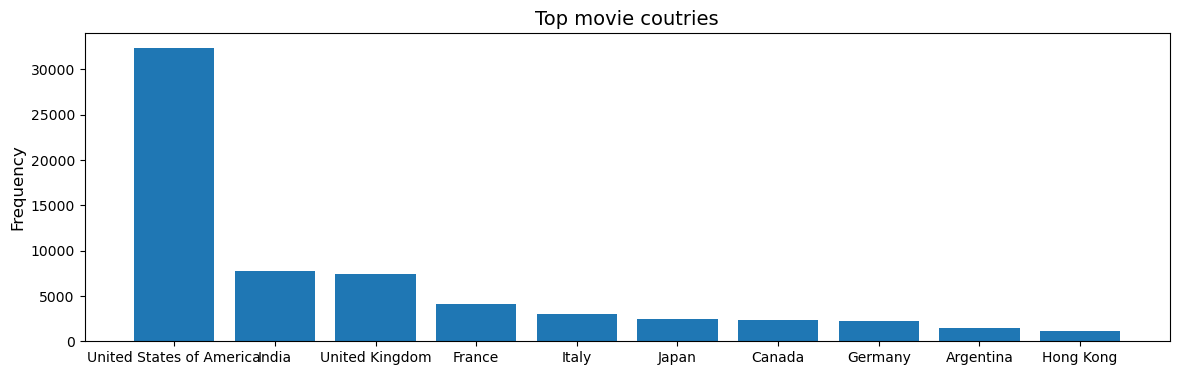

In [94]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])
a = to_1D(df_movie_meta['Movie countries']).value_counts().nlargest(10)

fig, ax = plt.subplots(figsize = (14,4))
ax.bar(a.index,
        a.values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Top movie coutries", size = 14)

Text(0.5, 1.0, 'Top genres')

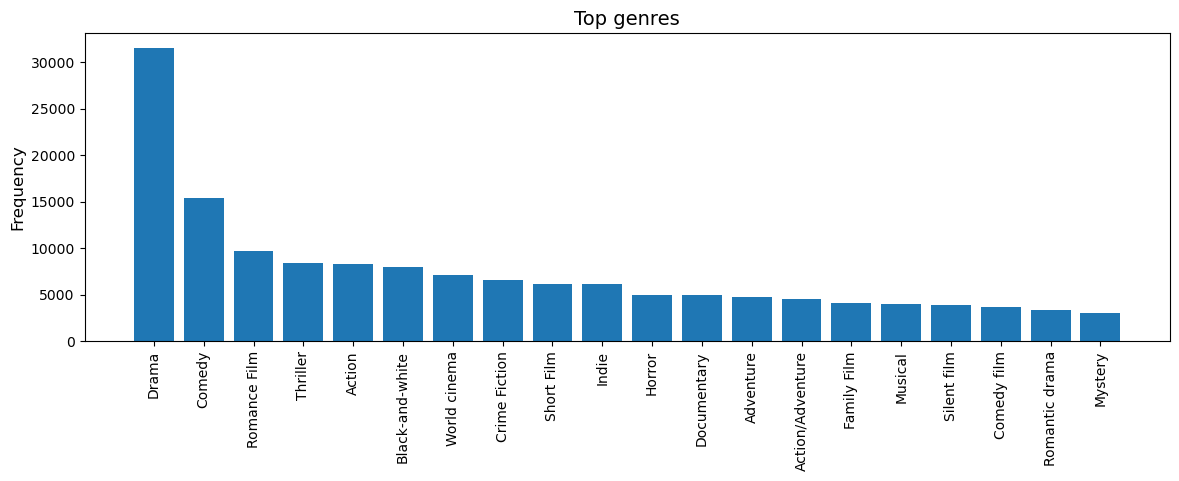

In [96]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

a = to_1D(df_movie_meta['Movie genres']).value_counts().nlargest(20)

fig, ax = plt.subplots(figsize = (14,4))
ax.bar(a.index,
        a.values)
plt.xticks(rotation=90)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Top genres", size = 14)

## Character metadata

In [99]:
#Importing character metadata
df_char_meta = pd.read_table("./data/MovieSummaries/character.metadata.tsv", header=None)
df_char_meta.columns=["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "character name", "Actor date of birth", "Actor gender", 
            "Actor height (in meters)", "Actor ethnicity (Freebase ID)", "Actor name", "Actor age at movie release", "Freebase character/actor map ID", 
            "Freebase character ID", "Freebase actor ID"]

In [101]:
df_char_meta.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
37772,19924644,/m/04q3sd6,2002-01,Bertram,NaN,M,NaN,NaN,T.C. Smith,NaN,/m/0n4n2_m,/m/0n4ndf_,/m/0n4n2y4
338679,16880343,/m/0409bvz,1981-12-11,NaN,NaN,NaN,NaN,NaN,Beatrice Fredman,NaN,/m/0gcjng_,NaN,/m/0gcjnh1
284566,35201805,/m/0j7hz5q,2012-08-18,NaN,1498,F,NaN,NaN,Mirabai,NaN,/m/0mzkkw5,NaN,/m/03h165
295761,23922445,/m/076xgt6,1976-07-07,NaN,NaN,F,NaN,NaN,Tamaki Katsura,NaN,/m/0gc1l9n,NaN,/m/0gc1l9q
302071,10111255,/m/02q256v,2007,NaN,1968-10-13,M,NaN,NaN,Pedro Telemaco,38.0,/m/02tb1j4,NaN,/m/0bg6g4
342847,23502201,/m/06w84zy,2009-12-11,Sherena K.,1987-12-08,F,1.70,/m/0dryh9k,Shazahn Padamsee,22.0,/m/07yk56d,/m/07yk56h,/m/09rv9x_
75789,628302,/m/02y9qc,1976-04-01,Susan Atkins,NaN,F,NaN,NaN,Nancy Wolfe,NaN,/m/0gc24_j,/m/0n3grmz,/m/0gc24_l
193429,21564646,/m/05h2tj8,1994,Carlotta,NaN,F,NaN,NaN,Kirsten Johnson,NaN,/m/0n58ljg,/m/0n58ljk,/m/0n58ljs
186627,5603725,/m/0dvsvf,2001-04-01,Mitchell Cabot,NaN,M,NaN,NaN,Cliff Roca,NaN,/m/0j8cx4b,/m/0j8cww7,/m/0j8cww4
431998,20313018,/m/04jhpdr,2010-05-26,Steven Arthur Younger,1969-02-05,M,1.75,/m/06gbnc,Michael Sheen,41.0,/m/052f26p,/m/0gz69w5,/m/01pkhw


In [107]:
print("Total size of the dataset: " + str(df_char_meta.shape[0]))

Total size of the dataset: 450669


In [111]:
print("Number of entries for which we don't have the gender: " + str(df_char_meta["Actor gender"].isnull().values.sum()))

Number of entries for which we don't have the gender: 45609


In [110]:
print("Number of entries for which we don't have the age at the movie release date: " + 
      str(df_char_meta["Actor age at movie release"].isnull().values.sum()))

Number of entries for which we don't have the age at the movie release date: 158113


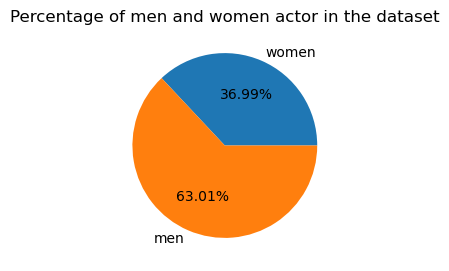

In [117]:
mylabels = ["women", "men"]
plt.figure(figsize=(3,3)) 
plt.pie(np.array([df_char_meta[df_char_meta['Actor gender'] == 'F']['Actor name'].nunique(),df_char_meta[df_char_meta['Actor gender'] == 'M']['Actor name'].nunique()]), labels = mylabels, autopct='%1.2f%%')
plt.title("Percentage of men and women actor in the dataset")
plt.show()

## Merging and cleaning the two datasets

In [147]:
df_merged_meta = pd.DataFrame(df_char_meta[["Freebase movie ID", "Actor gender", "Actor age at movie release"]])
df_merged_meta = pd.merge(df_merged_meta, df_movie_meta[["Freebase movie ID", "Movie release date", 
                                                         "Movie countries", "Movie genres"]], on="Freebase movie ID")

In [148]:
df_merged_meta.sample(10)

,Freebase movie ID,Actor gender,Actor age at movie release,Movie release date,Movie countries,Movie genres
359085,/m/02kvpf,M,NaN,2004,[United States of America],"[Thriller, Mystery, Horror, Psychological thri..."
66912,/m/060g9z,M,44.0,1958,[United States of America],"[Melodrama, Drama, Adventure]"
362012,/m/09g92k0,NaN,NaN,2009,[United States of America],"[Comedy, Indie]"
46793,/m/0kv4yd,F,34.0,2007,[India],"[Crime Fiction, Romance Film, Action, Drama]"
416406,/m/092h0k,M,45.0,2004,"[United States of America, Hungary]","[Drama, Musical, Fantasy]"
402016,/m/0bh7ngl,M,NaN,1995,"[Singapore, Hong Kong, China]","[Drama, Chinese Movies]"
119871,/m/051_24q,F,NaN,1928,[United Kingdom],[Adventure]
158024,/m/04x98l,M,58.0,1980,[United States of America],"[Parody, Science Fiction, Adventure, Western, ..."
354974,/m/01j1rb,F,NaN,2003,[United States of America],"[LGBT, Crime Fiction, Drama, Indie, Teen]"
284702,/m/02789mt,F,26.0,2000,[United States of America],"[Thriller, Psychological thriller, Teen]"


In [149]:
print("Size of the gloabal dataset: " + str(df_merged_meta.shape[0]))
df_merged_meta.dropna(subset=['Actor gender'], inplace = True)
print("Size after removing entries with no gender: " + str(df_merged_meta.shape[0]))
df_merged_meta.dropna(subset=['Actor age at movie release'], inplace = True)
print("Size after removing entries with no age at movie release: " + str(df_merged_meta.shape[0]))

Size of the gloabal dataset: 437830
Size after removing entries with no gender: 392446
Size after removing entries with no age at movie release: 290726
